<a href="https://colab.research.google.com/github/TiffanyNgai/Personality-classification/blob/main/MBTI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Machine learning projects/MBTI/mbti_1.csv"
data_df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_df

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [4]:
data_df.iloc[0,1]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

## Data preprocessing

In [5]:
mbti_df = pd.DataFrame(data={'mbti':["ISTJ", "ISFJ", "INFJ", "INTJ", 
                                     "ISTP", "ISFP", "INFP", "INTP",
                                     "ESTP", "ESFP", "ENFP", "ENTP",
                                     "ESTJ", "ESFJ", "ENFJ", "ENTJ"], 
                             'labelled_type':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]})
mbti_df

,mbti,labelled_type
0,ISTJ,0
1,ISFJ,1
2,INFJ,2
3,INTJ,3
4,ISTP,4
5,ISFP,5
6,INFP,6
7,INTP,7
8,ESTP,8
9,ESFP,9


In [6]:
labelled_data_df = data_df.merge(mbti_df, how='left', left_on='type', right_on='mbti')
labelled_data_df.drop(['type', 'mbti'], axis=1, inplace=True)
labelled_data_df

,posts,labelled_type
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,2
1,'I'm finding the lack of me in these posts ver...,11
2,'Good one _____ https://www.youtube.com/wat...,7
3,"'Dear INTP, I enjoyed our conversation the o...",3
4,'You're fired.|||That's another silly misconce...,15
...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908||...,5
8671,'So...if this thread already exists someplace ...,10
8672,'So many questions when i do these things. I ...,7
8673,'I am very conflicted right now when it comes ...,6


In [7]:
labelled_data_df.iloc[1,0]

"'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/6020d1f9da

In [8]:
labelled_data_df['clean_posts'] = labelled_data_df['posts'].str.lower()

labelled_data_df['clean_posts'] = labelled_data_df['clean_posts'].apply(lambda elem: re.sub(r"[|||]", " ", elem))  
labelled_data_df['clean_posts'] = labelled_data_df['clean_posts'].apply(lambda elem: re.sub(r"[/]", " ", elem))  

labelled_data_df['clean_posts'] = labelled_data_df['clean_posts'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
# Remove numbers
labelled_data_df['clean_posts'] = labelled_data_df['clean_posts'].apply(lambda elem: re.sub(r"\d+", "", elem))
labelled_data_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Possible set union at position 2
  This is separate from the ipykernel package so we can avoid doing imports until


,posts,labelled_type,clean_posts
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,2,wwwyoutubecom watchvqsxhcwekrw mediatumb...
1,'I'm finding the lack of me in these posts ver...,11,im finding the lack of me in these posts very ...
2,'Good one _____ https://www.youtube.com/wat...,7,good one wwwyoutubecom watchvfhigbolffgw...
3,"'Dear INTP, I enjoyed our conversation the o...",3,dear intp i enjoyed our conversation the oth...
4,'You're fired.|||That's another silly misconce...,15,youre fired thats another silly misconceptio...
...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908||...,5,wwwyoutubecom watchvtedhbh ixfp just becau...
8671,'So...if this thread already exists someplace ...,10,soif this thread already exists someplace else...
8672,'So many questions when i do these things. I ...,7,so many questions when i do these things i wo...
8673,'I am very conflicted right now when it comes ...,6,i am very conflicted right now when it comes t...


In [9]:
labelled_data_df.iloc[1,2]

'im finding the lack of me in these posts very alarming   sex can be boring if its in the same position often for example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary there isnt enough   giving new meaning to game theory   hello entp grin  thats all it takes than we converse and they do most of the flirting while i acknowledge their presence and return their words with smooth wordplay and more cheeky grins   this  lack of balance and hand eye coordination   real iq test i score  internet iq tests are funny i score s or higher  now like the former responses of this thread i will mention that i dont believe in the iq test before you banish   you know youre an entp when you vanish from a site for a year and a half return and find people are still commenting on your posts and liking your ideas thoughts you know youre an entp when you     imgimageshackus img  dfdaabbbejpg     imgadultdvdtalkcom accabc   i over think things somet

In [10]:
maxlen = 500

# Tokenize and encode text
t = Tokenizer()
t.fit_on_texts(labelled_data_df['clean_posts'])
posts_sequence = t.texts_to_sequences(labelled_data_df['clean_posts'])
encoded_posts = pad_sequences(posts_sequence, maxlen=maxlen)

In [11]:
print(np.all(np.isnan(encoded_posts)))
print(encoded_posts[-1])

False
[     5    365     18      4     61    683      5    891    127     24
      2    626    444     19   1516    582     58   2771     10      9
     71   2132      5      2    683    162    238     41     43     18
   9394      4    424    127     65    745     36     10      1    310
     70     52    686      5   1515    639      2    189    315     40
      7     78      7     15    599     39   1499      1    568    309
     51      7     67      1     42     78     18     11      4    402
    337    123     91      5     15    599      2    116      8     48
   1468     17    120     12   1499      5     12    193      1   6441
    504     75      1     37      2    700  16094   1886   1327     49
    181    177     16      4   3791   2771    891    188      3   2132
      1     49     20     16      2  16568     43      2     79    118
    199      6     64      5  24385   2315      1     28    120      3
     78      8     36   1433     66     13      1    138     12    476


In [12]:
one_hot_label = keras.utils.to_categorical(labelled_data_df['labelled_type'])

In [13]:
labelled_data_df['encoded_posts'] = encoded_posts.tolist()
labelled_data_df['one_hot_label'] = one_hot_label.tolist()
labelled_data_df

,posts,labelled_type,clean_posts,encoded_posts,one_hot_label
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,2,wwwyoutubecom watchvqsxhcwekrw mediatumb...,"[1082, 64, 170, 1103, 11, 39, 131, 2765, 3821,...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,'I'm finding the lack of me in these posts ver...,11,im finding the lack of me in these posts very ...,"[527, 144, 6403, 625, 18, 274, 10, 188, 8, 7, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,'Good one _____ https://www.youtube.com/wat...,7,good one wwwyoutubecom watchvfhigbolffgw...,"[6, 951, 27, 7872, 8, 22, 68, 22081, 1540, 7, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,"'Dear INTP, I enjoyed our conversation the o...",3,dear intp i enjoyed our conversation the oth...,"[95, 42907, 61, 466, 11973, 16, 2, 252, 6, 70,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,'You're fired.|||That's another silly misconce...,15,youre fired thats another silly misconceptio...,"[8720, 6313, 7422, 16, 58873, 32, 1018, 12, 24...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908||...,5,wwwyoutubecom watchvtedhbh ixfp just becau...,"[115, 4, 165026, 18, 251, 6, 10, 5, 1, 461, 15...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
8671,'So...if this thread already exists someplace ...,10,soif this thread already exists someplace else...,"[1001, 32, 3, 20, 265, 543, 5, 1546, 39, 1113,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8672,'So many questions when i do these things. I ...,7,so many questions when i do these things i wo...,"[211, 39, 760, 35, 7, 30, 139, 63, 2385, 13192...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
8673,'I am very conflicted right now when it comes ...,6,i am very conflicted right now when it comes t...,"[100, 16, 1381, 1, 737, 3, 595, 12, 110, 9, 40...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(encoded_posts, one_hot_label, test_size=0.3)

In [15]:
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

X_train: (6072, 500)
Y_train: (6072, 16)


In [16]:
#Ensure there is no NULL value
print(np.all(np.isnan(X_train)))
print(np.all(np.isnan(Y_train)))

False
False


In [17]:
X_train

array([[    3,    20,   354, ...,    77,   149,   246],
       [  227,    13,     1, ...,   108,    22,  1765],
       [ 4032,  1236,     9, ...,  3544,     5,  1139],
       ...,
       [    3,    10,   200, ...,    87,    15,     4],
       [    1,   107, 10310, ...,     8,    21,  4603],
       [   91,    18,  8150, ...,  4289,     1,   165]], dtype=int32)

In [18]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

##Create model

In [28]:
max_features = 20000
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)
# Add bidirectional LSTM
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
# x = layers.Dropout(rate=0.4)(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
# x = layers.Dropout(rate=0.4)(x)

# Add a classifier
outputs = layers.Dense(16, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 64)         41216     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 16)                1040      
                                                                 
Total params: 2,627,088
Trainable params: 2,627,088
Non-tra

## Model training

In [29]:
opt = keras.optimizers.Adam(learning_rate=0.00007)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=32, epochs=15, validation_data=(X_val, Y_val))

Epoch 1/15
190/190 [==============================] - 21s 82ms/step - loss: 2.6531 - accuracy: 0.1614 - val_loss: 2.3312 - val_accuracy: 0.2098
Epoch 2/15
190/190 [==============================] - 14s 74ms/step - loss: 2.3071 - accuracy: 0.2118 - val_loss: 2.2864 - val_accuracy: 0.2098
Epoch 3/15
190/190 [==============================] - 14s 74ms/step - loss: 2.2859 - accuracy: 0.2118 - val_loss: 2.2771 - val_accuracy: 0.2098
Epoch 4/15
190/190 [==============================] - 14s 73ms/step - loss: 2.2766 - accuracy: 0.2110 - val_loss: 2.2729 - val_accuracy: 0.2098
Epoch 5/15
190/190 [==============================] - 14s 74ms/step - loss: 2.2651 - accuracy: 0.2115 - val_loss: 2.2669 - val_accuracy: 0.2086
Epoch 6/15
190/190 [==============================] - 16s 85ms/step - loss: 2.2259 - accuracy: 0.2286 - val_loss: 2.2394 - val_accuracy: 0.2182
Epoch 7/15
190/190 [==============================] - 14s 75ms/step - loss: 2.1290 - accuracy: 0.2551 - val_loss: 2.2179 - val_accuracy:

## Model evaluation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


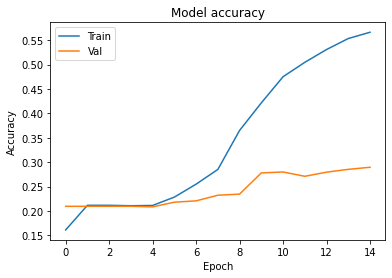

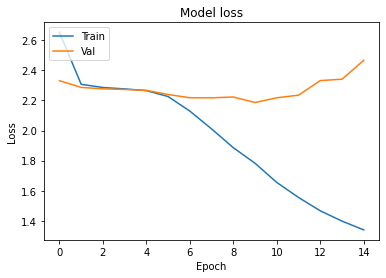

In [30]:
print(history.history.keys())
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Reference

- https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/
- https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
- https://keras.io/examples/nlp/bidirectional_lstm_imdb/
- https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
